# [TC1] Lab exercise 1: SVM training

In this lab exercise you will code 3 different algorithms to train a binary SVM classifier:

1. sub-gradient descent on the primal
2. projected gradient ascent on the dual
3. box constrained coordinate ascent on the dual

We will use a toy dataset generated via scikit learn, therefore it is easy to achieve 100% accuracy even if your algorithm is wrong! You should be extremely careful with you implementation, you need to check yourself that you precisely understand what you are coding. :)

Contrary to the course, here I ask you to have a hyperparameter to weight the regularization term.
You need to redo the math to check what this update changes in the primal and dual problem optimization algorithms.
If you don't want to mess with the math, you can first implement everything with the formula of the course, and then update to take into account the regularization term!

You need to submit both this completed notebook and a report.
See the course webpage for more information.

## Tensor operations

You **must** learn to code using tensor operation only.
In other word, you **should not** use for loops in your code when compute things.
The only for loops you need are already written!

The reason is that it makes everything simpler to understand and that Numpy (or other libraries) can vectorize the operations on CPU (or GPU in the case of libraries like Pytorch) to accelarate computation.

https://en.wikipedia.org/wiki/Array_programming

## Preliminaries

You need to install the following libraries: numpy, scikit-learn and matplotlib.
Please refer to the internet for instruction if you don't know how to do that.

In [1]:
import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
%matplotlib inline

Numpy is one of the most popular numerical computation library in Python.
For this lab exercise we are mainly interested in tensor computation.

It is really important that you take time to understand how Numpy works. A short tutorial is available here: https://cs231n.github.io/python-numpy-tutorial/

Take time to do a few test, understand the different operation, the different between in-place and out-of-place operations, etc.
The most important resource you **must** use is the numpy documentation.
As we usually say in computer science: Read The F*cking Manual https://numpy.org/doc/stable/reference/index.html

In [2]:
# create a 2D tensor of shape (2, 5) full of zeros
# by default the tensor will contain elements of type float
t = np.zeros((2, 5))
print("Shape of the tensor: ", t.shape)
print("Content:")
print(t)

Shape of the tensor:  (2, 5)
Content:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [3]:
# You can reshape tensors
# When you reshape a tensor, it does not change the data order in the underlying memory.
# By default, this is the "C array order", also called the row-major format.
# If you don't know about this, check the wikipedia page:
# https://en.wikipedia.org/wiki/Row-_and_column-major_order

# for example, the following operation will reshape t as a vector with ten elements
t = t.reshape(-1) # -1 means "put every there"
print(t.shape)

# here instead of having a vector we build a tensor with a single row with ten elements
t = t.reshape(1, -1)
# of cours we could have done t = t.reshape(1, 10)
print(t.shape)

# here a tensor with a single column with ten elements
t = t.reshape(-1, 1)
# of cours we could have done t = t.reshape(10, 1)
print(t.shape)

# reshape into the original shape
t = t.reshape(2, -1)
print(t.shape)

(10,)
(1, 10)
(10, 1)
(2, 5)


In [4]:
# this creates a vector with values from 0 to 3 (not included)
t = np.arange(4)
print(t)

# reshape
t = t.reshape((2, 2))
print(t)

# .T returns the transposed tensor
print(t.T)

[0 1 2 3]
[[0 1]
 [2 3]]
[[0 2]
 [1 3]]


In [5]:
# set the first element of the second row to one and display the new data
# this is an in-place operation: it directly modifes the tensor memory
t[1, 0] = 1.
print("New content:")
print(t)

New content:
[[0 1]
 [1 3]]


In [6]:
# multiply the content of the tensor by two
# this is an out-of-place operation: it does not modify the tensory memory but creates a new one
t2 = 2 * t

print("Original tensor:")
print(t)
print("New tensor:")
print(t2)

Original tensor:
[[0 1]
 [1 3]]
New tensor:
[[0 2]
 [2 6]]


In [7]:
# do the same thing but in-place
t *= 2
print("New content:")
print(t)

New content:
[[0 2]
 [2 6]]


In [8]:
# There are two multiplication operators:
# * is the element wise multiplication operator (also called the Hadamard product)
# @ is the matrix multiplication operator

a = np.arange(4).reshape(2, 2)
# one_like create a tensor with the same properties (i.e. type and shape) than the argument
# but filled with ones
b = 2 * np.ones_like(a) 

print("a:")
print(a)
print("b:")
print(b)
print()

# element wise multiplication
c = a * b
print("a * b:")
print(c)
print()

# matrix multiplication
c = a @ b
print("a @ b:")
print(c)

a:
[[0 1]
 [2 3]]
b:
[[2 2]
 [2 2]]

a * b:
[[0 2]
 [4 6]]

a @ b:
[[ 2  2]
 [10 10]]


In [9]:
# you can easily retrieve one row or one column of a tensor
print("a:")
print(a)
print()

print("first row of a:")
print(a[0])
print()

print("first column of a:")
print(a[:, 0])

a:
[[0 1]
 [2 3]]

first row of a:
[0 1]

first column of a:
[0 2]


In [10]:
# the same approach can be used to update the data in-place
print("a:")
print(a)
print()

# set the second colums elements to 10
a[:, 1] = 10.
print("after update:")
print(a)

a:
[[0 1]
 [2 3]]

after update:
[[ 0 10]
 [ 2 10]]


One of the most important feature you have to understand is **broadcasting**.
You can read the following article to understand operation broadcasting: https://numpy.org/devdocs/user/theory.broadcasting.html

It is a very important concept that is really helpful in numpy and other numerical computation library.
The documentation often explain of broadcasting is implemented for a given operation, check for example the matrix multiplication page: https://numpy.org/doc/stable/reference/generated/numpy.matmul.html

In [11]:
a = np.arange(6).reshape(2, -1)
print("a: ")
print(a)
print()

# we will multpliy the first row by 2 and the second row by 4 by using operation broadcasting
# np.array can be used to create a tensor from python data
b = np.array([2, 4]).reshape((2, 1))
c = a * b

print("new tensor:")
print(c)

a: 
[[0 1 2]
 [3 4 5]]

new tensor:
[[ 0  2  4]
 [12 16 20]]


## Plotting

We will use the following function to plot the data.
The first argument is mandatory and the two last are optional.

- x: data to plot. It must be of shape (number of datapoints, number of dimensions). Only the two first dimension will be used for horizontal and vertical dimensions, respectively. This means you can use the third dimension for the bias term!
- y: labels. It must be of shape (number of datapoints,), that is a single dimension vector. Value must be either -1 (displayed in blue) or +1 (displayed in red)
- a: parameters of a linear binary classifiers. Should be of shape (3,), that is a vector with three elements. The last element is the bias term! This argument is used to display the decision boundary (the hyperplane that separates the two classes)

In [12]:
# plot only the two first features as the two first dim
# other features will be ignored, so we can use them for the bias term for example
def plot(x, y=None, a=None):
    data_colors = np.array(["blue", "red"])
    if y is None:
        c = None
    else:
        c = data_colors[((y + 1) // 2).astype(int)]
        
    plt.scatter(x[:, 0], x[:, 1], c=c)
    
    if a is not None:
        left = np.min(x[:, 0] - 1)
        right = np.max(x[:, 0] + 1)

        left_y = -(a[2] + a[0]*left) / a[1]
        right_y = -(a[2] + a[0]*right) / a[1]

        plt.plot([left, right], [left_y, right_y], c='black')
    
    axes = plt.gca()
    axes.set_xlim([np.min(x[:, 0]) - 1,np.max(x[:, 0]) + 1])
    axes.set_ylim([np.min(x[:, 1]) - 1,np.max(x[:, 1]) + 1])
    plt.show()

## Data generation

We use scikit-learn to generate a toy dataset.
After you completed the lab exercise, you should play with dataset generation to generate non-separable data or even other kind of dataset, check the scikit-learn documentation! https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [13]:
X_no_bias, y_gold = sklearn.datasets.make_classification(
    n_samples=200,
    n_features=2,
    n_classes=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    class_sep=3. # default=1
)

# replace 0/1 labels with -1/1 labels
y_gold = y_gold * 2 - 1

# add a third feature which will be used for the bias term
X = np.empty((X_no_bias.shape[0], 3))
X[:,:2] = X_no_bias
X[:,2] = 1.

# create a diagonal vector containing labels
# (see the course to understand why this is useful)
Y_gold = np.diag(y_gold)

In [14]:
# so we have two different tensors containing the gold labels,
# use the most useful ones!
print(X.shape)
print(y_gold.shape)
print(Y_gold.shape)

(200, 3)
(200,)
(200, 200)


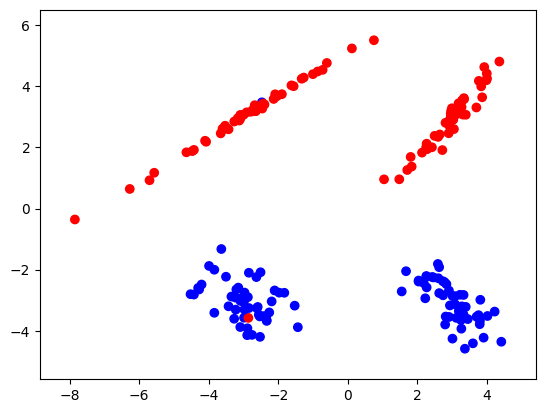

In [15]:
# plot the data
plot(X, y_gold)

# First step!

The first two functions to code are:
- predict(a, X): returns a vector of shape X.shape[0] containing the prediction given by the linear model parameterized by vector a, i.e. values in {-1, 1} for each datapoint (i.e. this function does both the scoring and prediction step)
- accuracy(gold, predicted): return the % of equal elements in the two vectors

In [16]:
# you can use np.sign here
def predict(a, X):
    # TODO
    return np.sign(X@a)

# you can use == to compare values between two tensors.
# Even if == returns a vector of boolean, you can sum them via t.sum() or np.sum(t)
# to count the number of True values
def accuracy(gold, predicted):
    # TODO
    return (gold == predicted).sum() / gold.shape[0]

In [17]:
# create a randomly initialized model
a = np.random.normal(loc=0.0, scale=0.1, size=3)

# compute the accuracy of the random model,
# it should return a value around 50,
# but the randomly generated model can also be way better/way worse
# (if you execute this cell many times you may even obtain an accuracy of 100%!)
accuracy(y_gold, predict(a, X))

0.96

# Training algorithm 1: sub-gradient descent on the primal problem

The objective function is defined as follows:
$$ \sum_i \max\left(0, 1 - X_{i} a y_i\right) + \frac{c}{2} \| a\|^2_2$$
where c is the regularization weight.

To implement this first you must first understand the following:

1. what is the gradient of the objective (there are two different cases depending of the result of the max!)
2. how to use tensor operations only for computing the objective and its gradient?

**Hint:**
for the second point, you will need to construct a mask, i.e. a vector containing values 0 and 1.
It needs to be computed as "mask = (right >= 0).astype(float)" where "right" is the right argument of the max.
Can you understand why? Can you explain why?

We need this mask to get the data points that satisfies the constraint of the right argument of the max being greater than zero
it's going to be helpful for the objective fct (the sum of the max) and the gradient (the sum -XiYi)

Accuracy at the last epoch:  0.99

Objective function:


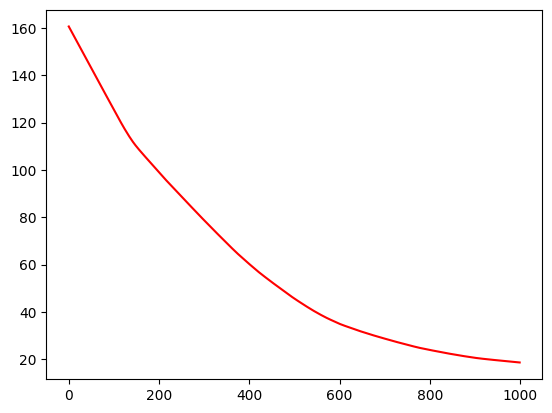

Classification accuracy:


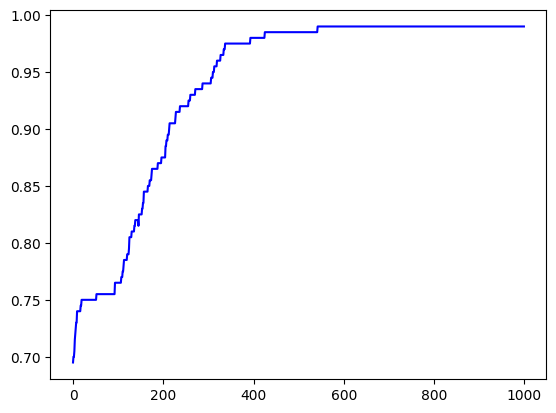

In [18]:
# hyperparameters: you can play with them!
step_size = 1e-6
regularization_weight = 1
n_epochs = 1000

# initialize the model randomly
a = np.random.normal(loc=0.0, scale=0.1, size=3)

# append to this list the objective value (or loss) at each epoch
objective_per_epoch = list()
# append to this list the accuracy at each epoch
# (evaluate on train directly, we are just playing with the optimization algorithm here)
# (but this is a bad practice, you should use development data in a real setting)
accuracy_per_epoch = list()

for _ in range(n_epochs):
    # compute the objective value (and the mask!)
    # TODO
    
    
    mask = (1 - (y_gold * (X @ a))) >= 0
    
    obj = (1 - (y_gold[mask] * (X[mask] @ a))).sum() + (regularization_weight / 2) * (a.T @ a)
    objective_per_epoch.append(obj)
    
    # compute the sub-gradient
    # TODO
    sub_gradient = (-X[mask].T @ Y_gold[mask]).sum(axis=1) + regularization_weight * a
    
    # update the parameters (you should use an in place operation)
    # TODO
    a -= step_size * sub_gradient
    
    # compute the accuracy after the update
    accuracy_per_epoch.append(accuracy(y_gold, predict(a, X)))

print("Accuracy at the last epoch: ", accuracy_per_epoch[-1])
print()

# display two plots:
# in red the objective value at each epoch,
# in blue accuracy at each epoch

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.show()


print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.show()


# Training algorithm 2: projected gradient ascent on the dual problem

In this second exercise, you need to optimize the dual via projected gradent ascent:

1. what is the dual objective when we add a hyperparameter to control the weight of the regularization term?
2. how do we retrieve primal variables from dual variables in this case?

In [19]:
def dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight):
    a = -1/regularization_weight*X.T @ Y_gold @ dual_vars
    return a

[3.82593284e-04 5.94684921e-02 1.08420217e-19]
[2.82765052e-04 1.07053446e-01 3.34063710e-05]
[-1.25507526e-04  1.45132352e-01  9.31923986e-05]
[-7.17860695e-04  1.75606512e-01  1.73683557e-04]
[-0.00140678  0.19999652  0.0002703 ]
[-0.00213196  0.21951857  0.00037934]
[-0.00285296  0.23514546  0.00049784]
[-0.00354378  0.24765536  0.00062338]
[-0.00418875  0.2576708   0.00075405]
[-0.00477946  0.26568982  0.00088828]
[-0.00531256  0.27211091  0.00102483]
[-0.00578713  0.27725961  0.00116393]
[-0.00616828  0.28166403  0.00135459]
[-0.0065009   0.28539907  0.00158379]
[-0.00679284  0.28846644  0.00182522]
[-0.00704882  0.29094097  0.00206711]
[-0.00723646  0.29309934  0.00234234]
[-0.00732861  0.29509623  0.00265055]
[-0.00745454  0.29696276  0.00295566]
[-0.00755987  0.29882627  0.00331872]
[-0.00788234  0.30069724  0.00365842]
[-0.00815785  0.30241495  0.00401839]
[-0.00851754  0.30422871  0.00438586]
[-0.00894009  0.305943    0.00475848]
[-0.00925572  0.3074318   0.00514203]
[-0.0094

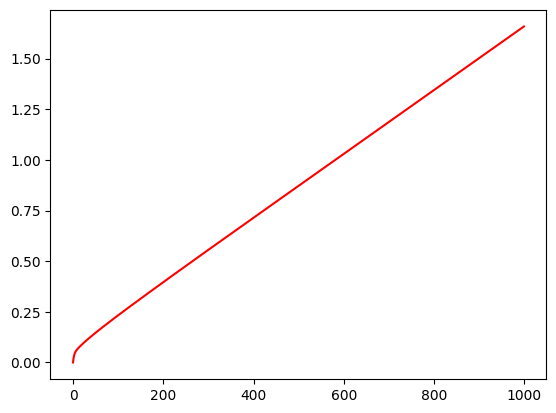

Classification accuracy:


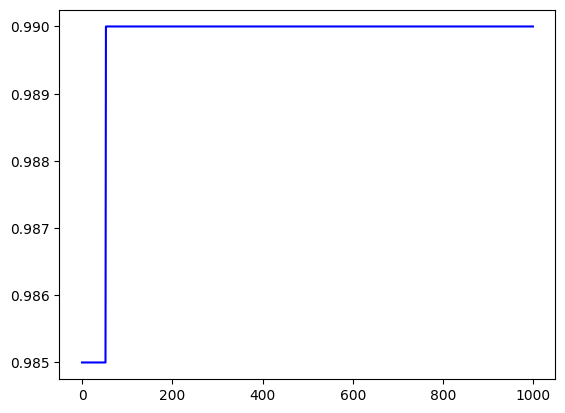

Number of support vectors:


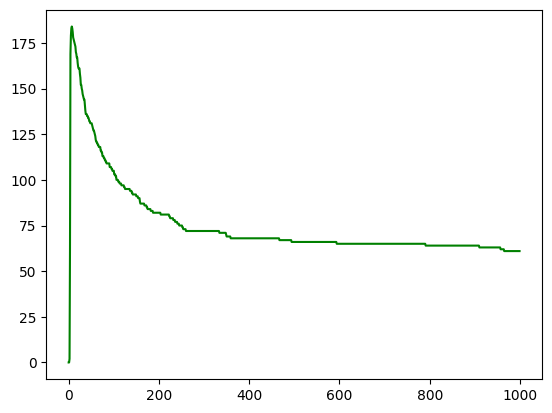

In [20]:
# hyperparameters: you can play with them!
step_size = 1e-4
regularization_weight = 1
n_epochs = 1000

# dual varariables initialization
# you can initialize them differently,
# only remember that you need each value to be between -1 and 0
dual_vars = np.zeros(X.shape[0])

objective_per_epoch = list()
accuracy_per_epoch = list()
support_vectors = list()


Y = np.diag(y_gold)
for _ in range(n_epochs):
    # compute the object
    # TODO
    obj = -dual_vars.sum(axis=0)-regularization_weight/2*( dual_vars.T @ Y_gold @ X @ X.T @ Y_gold @ dual_vars)

    objective_per_epoch.append(obj)
    
    # compute gradient
    # TODO
    grad = -1- regularization_weight*(Y_gold.T @ X @ X.T @ Y_gold @dual_vars)
    # projected sub-gradient step
    # you can use np.clip to project the new dual variables in the feasible space
    # TODO
    
    dual_vars = np.clip(dual_vars + step_size * grad, -1, 0)
    # evaluate
    a = dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight)
    print(a)
    accuracy_per_epoch.append(accuracy(y_gold, predict(a, X)))
    
    # compute the number of support vectors,
    # i.e. the number of dual vars != 0
    support_vectors.append(((dual_vars ** 2) > 1e-7).sum())

    
print("Stats at the last epoch:")
print(" - Accuracy: ", accuracy_per_epoch[-1])
print(" - Number of support vectors: ", support_vectors[-1])
print()


print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.show()


print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.show()

print("Number of support vectors:")
plt.plot(support_vectors, color="green")
plt.show()

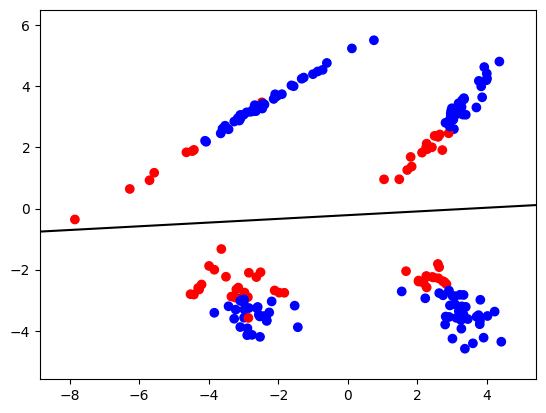

In [21]:
# This plot will show the support vectors in red together with the separating hyperplane,
# i.e. the blue points have a dual variable = 0

plot(X, ((dual_vars ** 2) > 1e-7)*2 - 1, dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight))

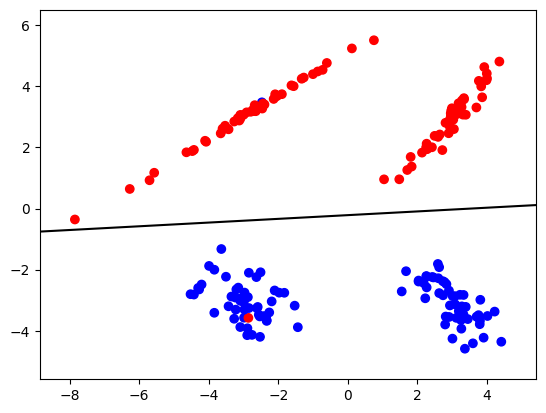

In [22]:
# this plot use the red/blue colors to indicate the gold class,
# you visualize if your model separating hyperplace correctly separates the data :)
plot(X, y_gold, dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight))

# Training algorithm 3: box constrained coordinate ascent on the dual problem

This last algorithm does not require a stepsize.
You will need a mask to compute the numerator in the dual variable update rule! (the sum does not include the update dual var)

Stats at the last epoch:
 - Accuracy:  0.01
 - Number of support vectors:  10

Objective function:


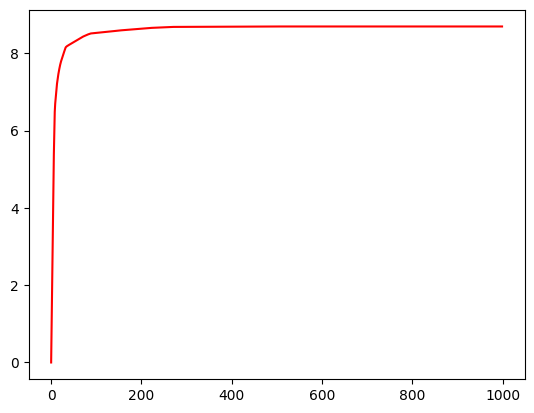

Classification accuracy:


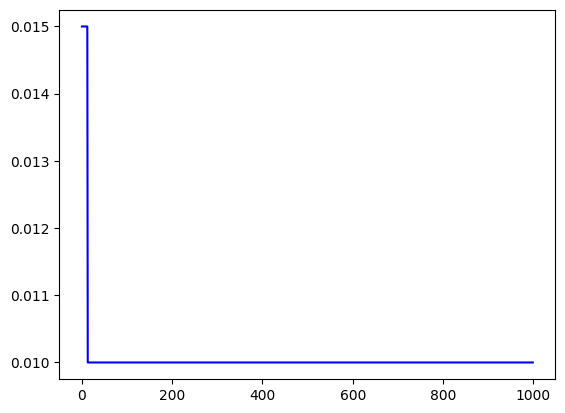

Number of support vectors:


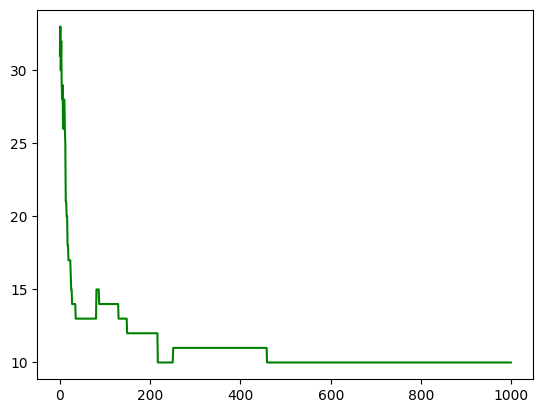

In [23]:
# hyperparameters: you can play with them!
regularization_weight = -1
n_epochs = 1000

# initialize dual variables
dual_vars = np.zeros(X.shape[0])

objective_per_epoch = list()
accuracy_per_epoch = list()
support_vectors = list()

Q = -Y_gold @ X @ X.T @ Y_gold
regularization_weights = np.array([regularization_weight]*X.shape[0])
for _ in range(n_epochs):
    # compute objective
    obj = 1/2 * dual_vars.T @ Q @ dual_vars + regularization_weights.T @ dual_vars
    objective_per_epoch.append(obj)
    
    # for each coordinate
    for k in range(X.shape[0]):
        # update the coordinate k (remember there are constraints on the dual vars!)
        # TODO
        mask = np.ones(X.shape[0], dtype=bool)
        mask[k] = False
        dual_vars[k] = np.clip((-regularization_weights[k]-dual_vars[mask].T @ Q[k,mask])/(Q[k,k]), -1, 0)
 


    # compute accuracy
    a = dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight)
    accuracy_per_epoch.append(accuracy(y_gold, predict(a, X)))
    
    # compute the number of support vectors,
    # i.e. the number of dual vars != 0
    support_vectors.append(((dual_vars ** 2) > 1e-7).sum())

    
print("Stats at the last epoch:")
print(" - Accuracy: ", accuracy_per_epoch[-1])
print(" - Number of support vectors: ", support_vectors[-1])
print()

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.show()


print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.show()

print("Number of support vectors:")
plt.plot(support_vectors, color="green")
plt.show()

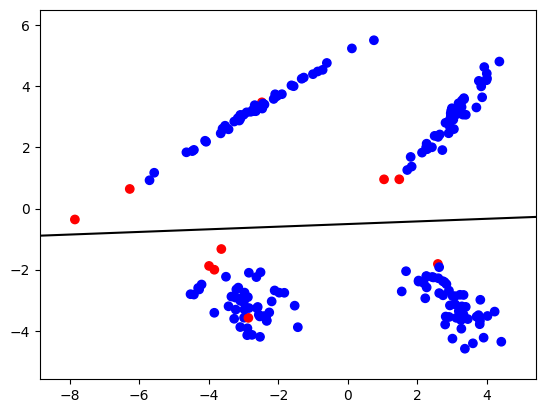

In [24]:
# This plot will show the support vectors in red together with the separating hyperplane,
# i.e. the blue points have a dual variable = 0

plot(X, ((dual_vars ** 2) > 1e-7)*2 - 1, dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight))

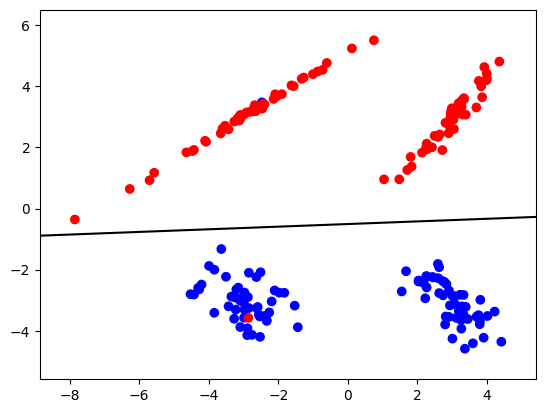

In [25]:
# this plot use the red/blue colors to indicate the gold class,
# you visualize if your model separating hyperplace correctly separates the data :)

plot(X, y_gold, dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight))